In [1]:
# Importing modules
import pandas as pd
import numpy as np
import re
import gensim
from gensim.models.coherencemodel import CoherenceModel
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from pprint import pprint
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis
import pyLDAvis.gensim
import os

np.random.seed(227)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tibyr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tibyr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Data Pre-processing

In [2]:
with open('megarhyme-wikinews.json', encoding='utf-8') as inputfile:
    data = pd.read_json(inputfile)
    
data = data.head(10000)
data.head()

,title,text,date,categories
0,President of China lunches with Brazilian Pres...,"Brazil\n\nHu Jintao, the President of the Peop...",2004-11-13,"[luiz inácio lula da silva, hu jintao, china, ..."
1,Palestinians to elect new president on January 9,Acting president Rawhi Fattuh has announced to...,2004-11-14,"[palestinian national authority, elections, mi..."
2,Brazilian delegation returns from Arafat funeral,PalestineThe delegation representing Brazil at...,2004-11-13,"[politics and conflicts, middle east, yasser a..."
3,Hearing begins over David Hookes death,A hearing started today over the death of Aust...,2004-11-15,"[cricket, crime and law, australia, oceania]"
4,Iran close to decision on nuclear program,Iran nuclear programIranian representatives sa...,2004-11-13,"[politics and conflicts, colin powell, nuclear..."


In [3]:
# remove categories and save for later
data_cleaned = data.drop(columns='categories')
categories = data['categories']

for col_name in ['text','title']:
    # remove \n formatting
    data_cleaned[col_name] = data_cleaned[col_name].map(lambda x: re.sub('\n', ' ', x))
    # remove punctuation
    data_cleaned[col_name] = data_cleaned[col_name].map(lambda x: re.sub('[,\.!?\(\)]', '', x))
    # convert to lowercase
    data_cleaned[col_name] = data_cleaned[col_name].map(lambda x: x.lower())

data_cleaned.head()

<>:9: DeprecationWarning: invalid escape sequence \.
<>:9: DeprecationWarning: invalid escape sequence \.
C:\Users\tibyr\AppData\Local\Temp/ipykernel_29416/1349800883.py:9: DeprecationWarning: invalid escape sequence \.
  data_cleaned[col_name] = data_cleaned[col_name].map(lambda x: re.sub('[,\.!?\(\)]', '', x))


,title,text,date
0,president of china lunches with brazilian pres...,brazil hu jintao the president of the people'...,2004-11-13
1,palestinians to elect new president on january 9,acting president rawhi fattuh has announced to...,2004-11-14
2,brazilian delegation returns from arafat funeral,palestinethe delegation representing brazil at...,2004-11-13
3,hearing begins over david hookes death,a hearing started today over the death of aust...,2004-11-15
4,iran close to decision on nuclear program,iran nuclear programiranian representatives sa...,2004-11-13


In [5]:
# how many distinct categories are there
len(list(set([item for sublist in categories for item in sublist])))

2285

In [62]:
# remove stop words
stop_words = stopwords.words('english')
# this seems to span almost every article so it's not useful for classification
stop_words.extend(['say'])

# tokenize the text
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

# lemmatize and stem words - change to present tense and reduce to root form
def lemmatize_stemming(text):
    stemmer = PorterStemmer()
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
        
# remove the stop words + lemmatize
def remove_stopwords(texts):
    return [[lemmatize_stemming(word) for word in simple_preprocess(str(doc)) 
             if lemmatize_stemming(word) not in stop_words] for doc in texts]

In [63]:
# tokenize sentences
data_processed = data_cleaned.text.values.tolist()
data_words = list(sent_to_words(data_processed))

# remove stop words
data_words = remove_stopwords(data_words)

data_words[:1][0][:10]

['brazil',
 'hu',
 'jintao',
 'presid',
 'peopl',
 'republ',
 'china',
 'lunch',
 'today',
 'presid']

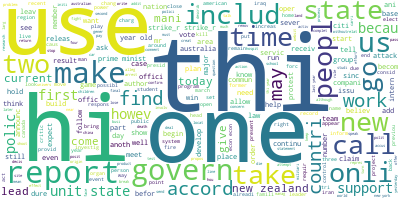

In [64]:
# Join the different processed titles together.
long_string = ','.join([item for sublist in data_words for item in sublist])

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=10000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

## Prepare for LDA

In [14]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)
texts = data_words

# Create bag of words corpus - Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 4), (8, 4), (9, 1), (10, 1), (11, 1), (12, 4), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 3), (23, 2), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]


## Train LDA model

In order to determine a good number of topics, let's consider the perplexity score.

In [ ]:
# Loop over different numbers of topics (k values) and calculate the perplexity score for each model
perplexity_scores = []
for k in range(100, 1200,200):
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=k)
    
    perplexity = lda_model.log_perplexity(corpus)
    
    perplexity_scores.append(perplexity)


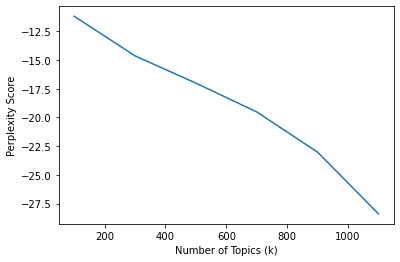

In [21]:
plt.plot(range(100, 1200,200), perplexity_scores)
plt.xlabel('Number of Topics (k)')
plt.ylabel('Perplexity Score')
plt.show()

Construct final LDA Model

In [48]:
# although the perplexity score suggested a larger k, for the sake of interpretability let's choose a smaller k
k = 50

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=k)

In [49]:
for idx, topic in lda_model.print_topics(-1)[:10]:
    print('Topic: {} \nWords: {}'.format(idx, topic))
    
# pprint(lda_model.print_topics())

Topic: 0 
Words: 0.006*"thi" + 0.005*"us" + 0.004*"year" + 0.004*"report" + 0.004*"hi" + 0.004*"two" + 0.004*"time" + 0.003*"new" + 0.003*"peopl" + 0.003*"one"
Topic: 1 
Words: 0.009*"thi" + 0.005*"us" + 0.005*"govern" + 0.005*"year" + 0.004*"hi" + 0.004*"state" + 0.004*"two" + 0.004*"peopl" + 0.003*"new" + 0.003*"first"
Topic: 2 
Words: 0.006*"thi" + 0.005*"use" + 0.005*"state" + 0.005*"new" + 0.004*"unit" + 0.004*"hi" + 0.004*"year" + 0.004*"also" + 0.004*"one" + 0.003*"make"
Topic: 3 
Words: 0.016*"strike_r" + 0.011*"ov" + 0.009*"econ" + 0.008*"new" + 0.006*"run" + 0.005*"match" + 0.005*"england" + 0.004*"year" + 0.004*"india" + 0.004*"make"
Topic: 4 
Words: 0.005*"thi" + 0.005*"take" + 0.005*"govern" + 0.004*"hi" + 0.004*"make" + 0.004*"elect" + 0.004*"new" + 0.004*"peopl" + 0.004*"year" + 0.004*"also"
Topic: 5 
Words: 0.006*"thi" + 0.005*"year" + 0.005*"hi" + 0.005*"us" + 0.005*"state" + 0.004*"time" + 0.004*"go" + 0.003*"peopl" + 0.003*"govern" + 0.003*"also"
Topic: 6 
Words: 0.0

## Evaluate the model

In [50]:
file_path = f'lda_model_{k}.pkl'
file_path

'lda_model_50.pkl'

In [51]:
# pickle the file so we can load it into pyLDAvis
with open(file_path, 'wb') as f:
    pickle.dump(lda_model, f)

In [52]:
pickled_lda = pickle.load(open(file_path, 'rb'))

In [53]:
vis = pyLDAvis.gensim.prepare(topic_model=pickled_lda, 
                              corpus=corpus, 
                              dictionary=id2word)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

## Review Results

In [73]:
test_idx = 27

# article text
data_cleaned.loc[[test_idx]]

,title,text,date
27,kmart to buy sears for us$11 billion,discount retailer kmart corp announced wednesd...,2004-11-17


In [55]:
# which topic is it assigned
lda_model.get_document_topics(corpus[test_idx])

[(45, 0.99255407)]

In [69]:
idx, topic = lda_model.print_topics(-1)[45]
# Split the string into individual elements
topic = topic.split(' + ')
# Join the elements with a new line character
topic = '\n'.join(topic)
print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 45 
Words: 0.008*"new"
0.008*"state"
0.008*"us"
0.007*"hi"
0.005*"thi"
0.005*"year"
0.005*"also"
0.004*"first"
0.004*"report"
0.004*"take"


In [57]:
# how well does this match the category
categories[test_idx]

['illinois',
 'wal-mart',
 'north america',
 'united states',
 'economy and business']

We can see there is some overlap between the pre-assigned category and the dervied topic cluster.